<a href="https://colab.research.google.com/github/edwardauron/DS-Unit-2-Sprint-4-Model-Validation/blob/master/Logisitic_Cross_Validation_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U -q kaggle
!pip install seaborn==0.9.0

In [0]:
!mkdir -p ~/.kaggle

In [0]:
import pandas as pd
import seaborn as sns

from google.colab import files
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, \
confusion_matrix, roc_auc_score

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from zipfile import ZipFile

In [6]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"otillieodd","key":"d170637b759479e1af28bb5ce552ebfd"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [8]:
!kaggle datasets download -d ntnu-testimon/paysim1

paysim1.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!ls

'kaggle (1).json'   paysim1.zip				   sample_data
 kaggle.json	    PS_20174392719_1491204439457_log.csv


In [10]:
!unzip paysim1.zip

Archive:  paysim1.zip
replace PS_20174392719_1491204439457_log.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [11]:
!ls

'kaggle (1).json'   paysim1.zip				   sample_data
 kaggle.json	    PS_20174392719_1491204439457_log.csv


In [12]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Let's label encode our names, and hot encode our types of payment for better processing. We choose not to label encode any numerical values, because they are attached to unique instances of customer interaction. If we had one input for multiple, like a lot, of outputs, label encoding would be a fine choice for numerical consistency.

In [0]:
le = LabelEncoder()
labels = ['nameOrig', 'nameDest']
for label in labels:
  df[label] = le.fit_transform(df[label].values)

In [15]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,PAYMENT,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,TRANSFER,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,CASH_OUT,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


In [16]:
df.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [0]:
df = pd.get_dummies(df, prefix=['type'])

In [18]:
df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0,0,0,0,1,0


In [19]:
df.step.max()

743

# Something weird
It looks like step goes all the way up to 743, i found some papers handling sequential data, but for now i think im actually going to drop step, because i honestly dont know how to handle it. 

In [0]:
df = df.drop('step', axis=1)

# I do not choose to scale the data. 
It is not required, and Sklearn has some rather robust handling for logistic models.

In [0]:
clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                         fit_intercept=True, intercept_scaling=1,
                         class_weight=None,random_state=42, solver='lbfgs', 
                         max_iter=10000, multi_class='warn', verbose=0, 
                         warm_start=False, n_jobs=None)

In [0]:
y = df['isFraud']
X = df.drop(['isFraud'], axis=1)

# Into the fold

I chose to use cross_val_predict because I wanted to eval my entire dataset. This...might...take awhile.

In [23]:
predicted = cross_val_predict(clf, X, y, cv=10)
print(accuracy_score(y, predicted))

0.9989961682451569


In [24]:
print(classification_report(y, predicted)) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6354407
           1       0.66      0.45      0.54      8213

   micro avg       1.00      1.00      1.00   6362620
   macro avg       0.83      0.73      0.77   6362620
weighted avg       1.00      1.00      1.00   6362620



In [36]:
print ('ROC_AUC', roc_auc_score(y, predicted))

ROC_AUC 0.7266252017370257


# Result

p = True positive / (True Positive + False Positive)
r = True positives / (True Positives + False Negative) 

66 percent of our fraudulents were correct from the total guesses of fraud. Not terrible. But not good.

We were only able to detect fraud 45 percent of the time though. Which is really bad. That means not only do we lack data, but fraud and not-fraud likely have some very similair characteristcs.  



# Looking at exact values


In [0]:
x = confusion_matrix(y, predicted)

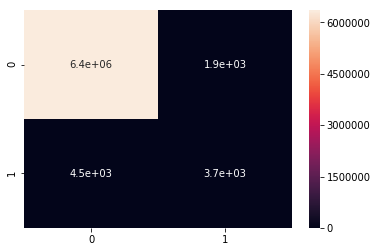

In [28]:
sns.heatmap(x, annot=True)